<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[23:10:00] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


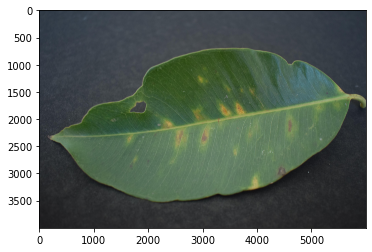

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

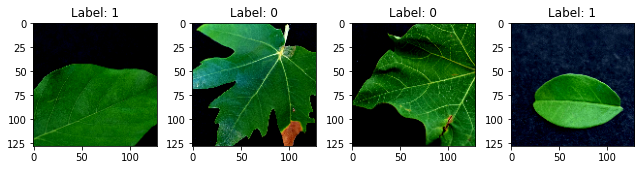

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
device = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, device=device)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), device=device))
model.hybridize()

[23:10:05] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[23:10:07] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.to_device(device))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.to_device(device))
            loss = loss_fn(outputs, label.to_device(device))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2559612662549704 samples/sec                   batch loss = 1.2618516683578491 | accuracy = 0.5


Epoch[1] Batch[10] Speed: 1.2613910369385004 samples/sec                   batch loss = 1.0285781621932983 | accuracy = 0.55


Epoch[1] Batch[15] Speed: 1.2660031850017568 samples/sec                   batch loss = 1.6729731559753418 | accuracy = 0.5333333333333333


Epoch[1] Batch[20] Speed: 1.269015587277301 samples/sec                   batch loss = 0.2944474220275879 | accuracy = 0.55


Epoch[1] Batch[25] Speed: 1.2657246744405217 samples/sec                   batch loss = 0.640211820602417 | accuracy = 0.59


Epoch[1] Batch[30] Speed: 1.2634323906699239 samples/sec                   batch loss = 0.523720920085907 | accuracy = 0.575


Epoch[1] Batch[35] Speed: 1.2632457445535699 samples/sec                   batch loss = 0.7332563400268555 | accuracy = 0.5642857142857143


Epoch[1] Batch[40] Speed: 1.2715248491727351 samples/sec                   batch loss = 0.7353658676147461 | accuracy = 0.58125


Epoch[1] Batch[45] Speed: 1.2617289382082657 samples/sec                   batch loss = 1.7090346813201904 | accuracy = 0.6


Epoch[1] Batch[50] Speed: 1.264980766161171 samples/sec                   batch loss = 0.6431660056114197 | accuracy = 0.605


Epoch[1] Batch[55] Speed: 1.260138247636473 samples/sec                   batch loss = 1.0378103256225586 | accuracy = 0.6136363636363636


Epoch[1] Batch[60] Speed: 1.264699368465044 samples/sec                   batch loss = 0.5934649705886841 | accuracy = 0.6166666666666667


Epoch[1] Batch[65] Speed: 1.2633231741179083 samples/sec                   batch loss = 0.6866051554679871 | accuracy = 0.6230769230769231


Epoch[1] Batch[70] Speed: 1.2655061352157453 samples/sec                   batch loss = 0.7949624061584473 | accuracy = 0.6178571428571429


Epoch[1] Batch[75] Speed: 1.265356857792147 samples/sec                   batch loss = 0.36456871032714844 | accuracy = 0.63


Epoch[1] Batch[80] Speed: 1.2579101790067788 samples/sec                   batch loss = 0.3250695765018463 | accuracy = 0.63125


Epoch[1] Batch[85] Speed: 1.2654123077619304 samples/sec                   batch loss = 0.5083231925964355 | accuracy = 0.6294117647058823


Epoch[1] Batch[90] Speed: 1.2724467887912663 samples/sec                   batch loss = 0.7437997460365295 | accuracy = 0.6277777777777778


Epoch[1] Batch[95] Speed: 1.263550856796501 samples/sec                   batch loss = 0.8744453191757202 | accuracy = 0.618421052631579


Epoch[1] Batch[100] Speed: 1.2650240692292607 samples/sec                   batch loss = 0.44506537914276123 | accuracy = 0.6225


Epoch[1] Batch[105] Speed: 1.2666645174592774 samples/sec                   batch loss = 0.5972409844398499 | accuracy = 0.6214285714285714


Epoch[1] Batch[110] Speed: 1.272407318602762 samples/sec                   batch loss = 0.5630775094032288 | accuracy = 0.6227272727272727


Epoch[1] Batch[115] Speed: 1.2703450596502504 samples/sec                   batch loss = 0.9775102138519287 | accuracy = 0.6282608695652174


Epoch[1] Batch[120] Speed: 1.2660935648983644 samples/sec                   batch loss = 0.3956998288631439 | accuracy = 0.6354166666666666


Epoch[1] Batch[125] Speed: 1.2636162367737944 samples/sec                   batch loss = 0.34110382199287415 | accuracy = 0.634


Epoch[1] Batch[130] Speed: 1.2646948877118123 samples/sec                   batch loss = 0.48542603850364685 | accuracy = 0.6423076923076924


Epoch[1] Batch[135] Speed: 1.2684359925136248 samples/sec                   batch loss = 0.42906245589256287 | accuracy = 0.6462962962962963


Epoch[1] Batch[140] Speed: 1.2721168200233781 samples/sec                   batch loss = 0.3031291365623474 | accuracy = 0.6446428571428572


Epoch[1] Batch[145] Speed: 1.2728145872065915 samples/sec                   batch loss = 0.4969275891780853 | accuracy = 0.6396551724137931


Epoch[1] Batch[150] Speed: 1.265498594143224 samples/sec                   batch loss = 0.37365907430648804 | accuracy = 0.64


Epoch[1] Batch[155] Speed: 1.2693493270651268 samples/sec                   batch loss = 0.2958219051361084 | accuracy = 0.6435483870967742


Epoch[1] Batch[160] Speed: 1.270799809605932 samples/sec                   batch loss = 0.456627756357193 | accuracy = 0.6375


Epoch[1] Batch[165] Speed: 1.2704179747782458 samples/sec                   batch loss = 0.40381088852882385 | accuracy = 0.6393939393939394


Epoch[1] Batch[170] Speed: 1.2656008358274258 samples/sec                   batch loss = 0.7435240745544434 | accuracy = 0.6411764705882353


Epoch[1] Batch[175] Speed: 1.2656082826459103 samples/sec                   batch loss = 0.6416964530944824 | accuracy = 0.6414285714285715


Epoch[1] Batch[180] Speed: 1.265416507269131 samples/sec                   batch loss = 0.38677436113357544 | accuracy = 0.6458333333333334


Epoch[1] Batch[185] Speed: 1.2763286271492456 samples/sec                   batch loss = 0.582115113735199 | accuracy = 0.6445945945945946


Epoch[1] Batch[190] Speed: 1.269667964571445 samples/sec                   batch loss = 0.21163608133792877 | accuracy = 0.6486842105263158


Epoch[1] Batch[195] Speed: 1.2648456300549447 samples/sec                   batch loss = 0.4269402325153351 | accuracy = 0.65


Epoch[1] Batch[200] Speed: 1.2648855861369057 samples/sec                   batch loss = 0.5105651617050171 | accuracy = 0.65375


Epoch[1] Batch[205] Speed: 1.2652082834669565 samples/sec                   batch loss = 1.545672059059143 | accuracy = 0.6524390243902439


Epoch[1] Batch[210] Speed: 1.2674685276816715 samples/sec                   batch loss = 0.9111423492431641 | accuracy = 0.6523809523809524


Epoch[1] Batch[215] Speed: 1.2718667559900803 samples/sec                   batch loss = 0.6501687169075012 | accuracy = 0.65


Epoch[1] Batch[220] Speed: 1.2699665742015935 samples/sec                   batch loss = 0.710900068283081 | accuracy = 0.6522727272727272


Epoch[1] Batch[225] Speed: 1.2734465188570812 samples/sec                   batch loss = 0.938287079334259 | accuracy = 0.6555555555555556


Epoch[1] Batch[230] Speed: 1.271884497362676 samples/sec                   batch loss = 0.4403984546661377 | accuracy = 0.657608695652174


Epoch[1] Batch[235] Speed: 1.2722730032028229 samples/sec                   batch loss = 0.35206905007362366 | accuracy = 0.6595744680851063


Epoch[1] Batch[240] Speed: 1.2743513079345938 samples/sec                   batch loss = 0.5796404480934143 | accuracy = 0.6583333333333333


Epoch[1] Batch[245] Speed: 1.2663428930411063 samples/sec                   batch loss = 1.145915150642395 | accuracy = 0.6591836734693878


Epoch[1] Batch[250] Speed: 1.2693013099577701 samples/sec                   batch loss = 1.1290161609649658 | accuracy = 0.657


Epoch[1] Batch[255] Speed: 1.2728498336485512 samples/sec                   batch loss = 1.0282143354415894 | accuracy = 0.6588235294117647


Epoch[1] Batch[260] Speed: 1.265715889407263 samples/sec                   batch loss = 0.5822098851203918 | accuracy = 0.6576923076923077


Epoch[1] Batch[265] Speed: 1.2668262518478874 samples/sec                   batch loss = 0.9614243507385254 | accuracy = 0.6547169811320754


Epoch[1] Batch[270] Speed: 1.2675239713597817 samples/sec                   batch loss = 0.5055596828460693 | accuracy = 0.6546296296296297


Epoch[1] Batch[275] Speed: 1.2598452821477935 samples/sec                   batch loss = 0.5880169868469238 | accuracy = 0.6572727272727272


Epoch[1] Batch[280] Speed: 1.26805634339343 samples/sec                   batch loss = 0.34119418263435364 | accuracy = 0.6589285714285714


Epoch[1] Batch[285] Speed: 1.266074838193991 samples/sec                   batch loss = 0.5630199313163757 | accuracy = 0.6570175438596492


Epoch[1] Batch[290] Speed: 1.2706483184291393 samples/sec                   batch loss = 1.1290665864944458 | accuracy = 0.656896551724138


Epoch[1] Batch[295] Speed: 1.2644844234211428 samples/sec                   batch loss = 0.7390548586845398 | accuracy = 0.6601694915254237


Epoch[1] Batch[300] Speed: 1.267808256237095 samples/sec                   batch loss = 0.7855315804481506 | accuracy = 0.6625


Epoch[1] Batch[305] Speed: 1.2642464010660617 samples/sec                   batch loss = 0.7799755334854126 | accuracy = 0.6631147540983606


Epoch[1] Batch[310] Speed: 1.2679238073530321 samples/sec                   batch loss = 0.9193495512008667 | accuracy = 0.6637096774193548


Epoch[1] Batch[315] Speed: 1.2643050884063955 samples/sec                   batch loss = 1.20901358127594 | accuracy = 0.6642857142857143


Epoch[1] Batch[320] Speed: 1.2649231605074616 samples/sec                   batch loss = 0.7252358794212341 | accuracy = 0.6640625


Epoch[1] Batch[325] Speed: 1.270462901590258 samples/sec                   batch loss = 0.3501700460910797 | accuracy = 0.6661538461538462


Epoch[1] Batch[330] Speed: 1.2751960274168557 samples/sec                   batch loss = 0.6837733387947083 | accuracy = 0.6659090909090909


Epoch[1] Batch[335] Speed: 1.2725455232376321 samples/sec                   batch loss = 0.44261330366134644 | accuracy = 0.6671641791044776


Epoch[1] Batch[340] Speed: 1.2621991895757847 samples/sec                   batch loss = 0.39208996295928955 | accuracy = 0.6661764705882353


Epoch[1] Batch[345] Speed: 1.2635382003191 samples/sec                   batch loss = 0.3123463988304138 | accuracy = 0.6688405797101449


Epoch[1] Batch[350] Speed: 1.270941805220165 samples/sec                   batch loss = 0.48012644052505493 | accuracy = 0.6707142857142857


Epoch[1] Batch[355] Speed: 1.2632613438497087 samples/sec                   batch loss = 0.23477742075920105 | accuracy = 0.671830985915493


Epoch[1] Batch[360] Speed: 1.2603425335075369 samples/sec                   batch loss = 0.43275511264801025 | accuracy = 0.6729166666666667


Epoch[1] Batch[365] Speed: 1.2539532428030162 samples/sec                   batch loss = 0.8558211326599121 | accuracy = 0.6712328767123288


Epoch[1] Batch[370] Speed: 1.2580446861437502 samples/sec                   batch loss = 0.5461523532867432 | accuracy = 0.6722972972972973


Epoch[1] Batch[375] Speed: 1.2717352538559945 samples/sec                   batch loss = 0.6909061074256897 | accuracy = 0.6726666666666666


Epoch[1] Batch[380] Speed: 1.2630157947588494 samples/sec                   batch loss = 1.1341822147369385 | accuracy = 0.6710526315789473


Epoch[1] Batch[385] Speed: 1.257832279892681 samples/sec                   batch loss = 0.6192808747291565 | accuracy = 0.6727272727272727


Epoch[1] Batch[390] Speed: 1.2611728538537705 samples/sec                   batch loss = 0.8084217309951782 | accuracy = 0.6711538461538461


Epoch[1] Batch[395] Speed: 1.264143330322646 samples/sec                   batch loss = 0.5082539916038513 | accuracy = 0.6721518987341772


Epoch[1] Batch[400] Speed: 1.2712560411731018 samples/sec                   batch loss = 0.3959676921367645 | accuracy = 0.673125


Epoch[1] Batch[405] Speed: 1.2667870339216993 samples/sec                   batch loss = 0.9952835440635681 | accuracy = 0.6722222222222223


Epoch[1] Batch[410] Speed: 1.2540239133757713 samples/sec                   batch loss = 0.22693392634391785 | accuracy = 0.6731707317073171


Epoch[1] Batch[415] Speed: 1.2597806701808716 samples/sec                   batch loss = 0.31797292828559875 | accuracy = 0.6753012048192771


Epoch[1] Batch[420] Speed: 1.2677753002435923 samples/sec                   batch loss = 0.4840540885925293 | accuracy = 0.6767857142857143


Epoch[1] Batch[425] Speed: 1.2649790493605404 samples/sec                   batch loss = 0.3504490256309509 | accuracy = 0.6776470588235294


Epoch[1] Batch[430] Speed: 1.2655597844268827 samples/sec                   batch loss = 0.3195696473121643 | accuracy = 0.6779069767441861


Epoch[1] Batch[435] Speed: 1.2596889193326686 samples/sec                   batch loss = 0.4784131348133087 | accuracy = 0.6787356321839081


Epoch[1] Batch[440] Speed: 1.2656227946465382 samples/sec                   batch loss = 0.2879551947116852 | accuracy = 0.6806818181818182


Epoch[1] Batch[445] Speed: 1.266663465507968 samples/sec                   batch loss = 0.36991026997566223 | accuracy = 0.6808988764044944


Epoch[1] Batch[450] Speed: 1.271779309826224 samples/sec                   batch loss = 0.24757762253284454 | accuracy = 0.6811111111111111


Epoch[1] Batch[455] Speed: 1.2636484058252861 samples/sec                   batch loss = 0.3778192400932312 | accuracy = 0.6813186813186813


Epoch[1] Batch[460] Speed: 1.2596415357262987 samples/sec                   batch loss = 1.5529636144638062 | accuracy = 0.6815217391304348


Epoch[1] Batch[465] Speed: 1.2625886413939966 samples/sec                   batch loss = 0.42345088720321655 | accuracy = 0.6827956989247311


Epoch[1] Batch[470] Speed: 1.2675210027497985 samples/sec                   batch loss = 0.42303723096847534 | accuracy = 0.6829787234042554


Epoch[1] Batch[475] Speed: 1.2643367208560272 samples/sec                   batch loss = 0.1342529058456421 | accuracy = 0.6847368421052632


Epoch[1] Batch[480] Speed: 1.2583192605195095 samples/sec                   batch loss = 0.21887129545211792 | accuracy = 0.6854166666666667


Epoch[1] Batch[485] Speed: 1.2641203750795857 samples/sec                   batch loss = 0.7281714081764221 | accuracy = 0.6850515463917526


Epoch[1] Batch[490] Speed: 1.2631595748965982 samples/sec                   batch loss = 0.31862103939056396 | accuracy = 0.685204081632653


Epoch[1] Batch[495] Speed: 1.2667339501091286 samples/sec                   batch loss = 0.550563395023346 | accuracy = 0.6843434343434344


Epoch[1] Batch[500] Speed: 1.2632783703504695 samples/sec                   batch loss = 0.5512807965278625 | accuracy = 0.687


Epoch[1] Batch[505] Speed: 1.257622773495887 samples/sec                   batch loss = 0.5691770911216736 | accuracy = 0.6876237623762376


Epoch[1] Batch[510] Speed: 1.2647493262471494 samples/sec                   batch loss = 0.7370884418487549 | accuracy = 0.6867647058823529


Epoch[1] Batch[515] Speed: 1.262580564953316 samples/sec                   batch loss = 0.4833311140537262 | accuracy = 0.6873786407766991


Epoch[1] Batch[520] Speed: 1.2692912268267682 samples/sec                   batch loss = 0.5994727611541748 | accuracy = 0.6875


Epoch[1] Batch[525] Speed: 1.2682826674399585 samples/sec                   batch loss = 0.49313873052597046 | accuracy = 0.6880952380952381


Epoch[1] Batch[530] Speed: 1.2627567498322694 samples/sec                   batch loss = 0.10667506605386734 | accuracy = 0.6882075471698114


Epoch[1] Batch[535] Speed: 1.2644243853127886 samples/sec                   batch loss = 0.40824249386787415 | accuracy = 0.6892523364485982


Epoch[1] Batch[540] Speed: 1.2645482797292211 samples/sec                   batch loss = 0.7697702646255493 | accuracy = 0.6898148148148148


Epoch[1] Batch[545] Speed: 1.266426056110776 samples/sec                   batch loss = 0.4353824555873871 | accuracy = 0.691743119266055


Epoch[1] Batch[550] Speed: 1.2627794654846856 samples/sec                   batch loss = 0.20602639019489288 | accuracy = 0.6945454545454546


Epoch[1] Batch[555] Speed: 1.2608050245781295 samples/sec                   batch loss = 0.6807296872138977 | accuracy = 0.6941441441441442


Epoch[1] Batch[560] Speed: 1.2550251226208915 samples/sec                   batch loss = 0.40742799639701843 | accuracy = 0.69375


Epoch[1] Batch[565] Speed: 1.2687590649463634 samples/sec                   batch loss = 0.5986447930335999 | accuracy = 0.6924778761061947


Epoch[1] Batch[570] Speed: 1.264836857219798 samples/sec                   batch loss = 0.460424542427063 | accuracy = 0.6921052631578948


Epoch[1] Batch[575] Speed: 1.2629827071385045 samples/sec                   batch loss = 0.36562904715538025 | accuracy = 0.6921739130434783


Epoch[1] Batch[580] Speed: 1.2689127931491542 samples/sec                   batch loss = 0.4639437794685364 | accuracy = 0.6905172413793104


Epoch[1] Batch[585] Speed: 1.2644206688553767 samples/sec                   batch loss = 0.5867993235588074 | accuracy = 0.6905982905982906


Epoch[1] Batch[590] Speed: 1.2634997566342674 samples/sec                   batch loss = 0.7113465666770935 | accuracy = 0.6911016949152542


Epoch[1] Batch[595] Speed: 1.2651176483185622 samples/sec                   batch loss = 0.6451744437217712 | accuracy = 0.6928571428571428


Epoch[1] Batch[600] Speed: 1.2611705785478826 samples/sec                   batch loss = 0.6110563278198242 | accuracy = 0.69375


Epoch[1] Batch[605] Speed: 1.2615766610194599 samples/sec                   batch loss = 0.5509828329086304 | accuracy = 0.6950413223140496


Epoch[1] Batch[610] Speed: 1.2676481866336127 samples/sec                   batch loss = 0.27477872371673584 | accuracy = 0.6963114754098361


Epoch[1] Batch[615] Speed: 1.2736619111515153 samples/sec                   batch loss = 0.8915917873382568 | accuracy = 0.6971544715447154


Epoch[1] Batch[620] Speed: 1.2744906129357194 samples/sec                   batch loss = 0.19045978784561157 | accuracy = 0.6975806451612904


Epoch[1] Batch[625] Speed: 1.2622673737841044 samples/sec                   batch loss = 0.19321757555007935 | accuracy = 0.698


Epoch[1] Batch[630] Speed: 1.2711416154905595 samples/sec                   batch loss = 0.73075932264328 | accuracy = 0.698015873015873


Epoch[1] Batch[635] Speed: 1.26673710631953 samples/sec                   batch loss = 0.3967558443546295 | accuracy = 0.6976377952755906


Epoch[1] Batch[640] Speed: 1.26616608833223 samples/sec                   batch loss = 0.3484596014022827 | accuracy = 0.69765625


Epoch[1] Batch[645] Speed: 1.2699184142611735 samples/sec                   batch loss = 0.478360652923584 | accuracy = 0.6976744186046512


Epoch[1] Batch[650] Speed: 1.2690184669044366 samples/sec                   batch loss = 0.6797600388526917 | accuracy = 0.698076923076923


Epoch[1] Batch[655] Speed: 1.2625857908737226 samples/sec                   batch loss = 0.1490597277879715 | accuracy = 0.6988549618320611


Epoch[1] Batch[660] Speed: 1.2712765590668464 samples/sec                   batch loss = 0.2508082389831543 | accuracy = 0.6984848484848485


Epoch[1] Batch[665] Speed: 1.2748429319809347 samples/sec                   batch loss = 0.13351969420909882 | accuracy = 0.6992481203007519


Epoch[1] Batch[670] Speed: 1.2676420567044344 samples/sec                   batch loss = 0.5120607614517212 | accuracy = 0.6996268656716418


Epoch[1] Batch[675] Speed: 1.2694921514130437 samples/sec                   batch loss = 0.5228336453437805 | accuracy = 0.7007407407407408


Epoch[1] Batch[680] Speed: 1.270700768401653 samples/sec                   batch loss = 0.5507562160491943 | accuracy = 0.7011029411764705


Epoch[1] Batch[685] Speed: 1.2756012040084854 samples/sec                   batch loss = 0.9160575866699219 | accuracy = 0.7010948905109489


Epoch[1] Batch[690] Speed: 1.2720282785903951 samples/sec                   batch loss = 0.23851345479488373 | accuracy = 0.7007246376811594


Epoch[1] Batch[695] Speed: 1.2724498770266635 samples/sec                   batch loss = 0.4299095571041107 | accuracy = 0.7003597122302159


Epoch[1] Batch[700] Speed: 1.2662279165811305 samples/sec                   batch loss = 0.503458559513092 | accuracy = 0.7021428571428572


Epoch[1] Batch[705] Speed: 1.2640096110807697 samples/sec                   batch loss = 0.1347200870513916 | accuracy = 0.7028368794326241


Epoch[1] Batch[710] Speed: 1.2628607352845536 samples/sec                   batch loss = 0.704546332359314 | accuracy = 0.7024647887323944


Epoch[1] Batch[715] Speed: 1.2648235074867662 samples/sec                   batch loss = 0.8005297183990479 | accuracy = 0.7027972027972028


Epoch[1] Batch[720] Speed: 1.2676270194730148 samples/sec                   batch loss = 0.31436848640441895 | accuracy = 0.7027777777777777


Epoch[1] Batch[725] Speed: 1.2655137718364693 samples/sec                   batch loss = 0.4575052857398987 | accuracy = 0.7027586206896552


Epoch[1] Batch[730] Speed: 1.264784604157746 samples/sec                   batch loss = 0.7274687886238098 | accuracy = 0.7030821917808219


Epoch[1] Batch[735] Speed: 1.2649448096990168 samples/sec                   batch loss = 0.3213494122028351 | accuracy = 0.7034013605442176


Epoch[1] Batch[740] Speed: 1.2686213937158188 samples/sec                   batch loss = 0.37273678183555603 | accuracy = 0.7040540540540541


Epoch[1] Batch[745] Speed: 1.2657042398773255 samples/sec                   batch loss = 0.4655381441116333 | accuracy = 0.7053691275167785


Epoch[1] Batch[750] Speed: 1.2593133531659308 samples/sec                   batch loss = 0.4074636995792389 | accuracy = 0.704


Epoch[1] Batch[755] Speed: 1.2662989261769382 samples/sec                   batch loss = 0.30785253643989563 | accuracy = 0.704635761589404


Epoch[1] Batch[760] Speed: 1.270247628092758 samples/sec                   batch loss = 0.7232255339622498 | accuracy = 0.7042763157894737


Epoch[1] Batch[765] Speed: 1.2640858009135327 samples/sec                   batch loss = 0.6864271759986877 | accuracy = 0.7035947712418301


Epoch[1] Batch[770] Speed: 1.2653862523515917 samples/sec                   batch loss = 0.8753858804702759 | accuracy = 0.7042207792207792


Epoch[1] Batch[775] Speed: 1.2559381371032303 samples/sec                   batch loss = 0.19154787063598633 | accuracy = 0.7038709677419355


Epoch[1] Batch[780] Speed: 1.262693359426302 samples/sec                   batch loss = 0.4228707253932953 | accuracy = 0.705448717948718


Epoch[1] Batch[785] Speed: 1.2608236904646672 samples/sec                   batch loss = 0.7534336447715759 | accuracy = 0.7054140127388535


[Epoch 1] training: accuracy=0.7046319796954315
[Epoch 1] time cost: 649.9628753662109
[Epoch 1] validation: validation accuracy=0.7222222222222222


Epoch[2] Batch[5] Speed: 1.2558147020122643 samples/sec                   batch loss = 0.4763545095920563 | accuracy = 0.8


Epoch[2] Batch[10] Speed: 1.2666890953644472 samples/sec                   batch loss = 0.5015125274658203 | accuracy = 0.775


Epoch[2] Batch[15] Speed: 1.2702144489897773 samples/sec                   batch loss = 0.5207403898239136 | accuracy = 0.75


Epoch[2] Batch[20] Speed: 1.2624456561653088 samples/sec                   batch loss = 0.324912965297699 | accuracy = 0.7875


Epoch[2] Batch[25] Speed: 1.2619422829616216 samples/sec                   batch loss = 1.1375609636306763 | accuracy = 0.81


Epoch[2] Batch[30] Speed: 1.265609714736435 samples/sec                   batch loss = 0.8603900074958801 | accuracy = 0.8083333333333333


Epoch[2] Batch[35] Speed: 1.268138581415875 samples/sec                   batch loss = 1.2937915325164795 | accuracy = 0.8


Epoch[2] Batch[40] Speed: 1.2638181294436832 samples/sec                   batch loss = 0.33012205362319946 | accuracy = 0.78125


Epoch[2] Batch[45] Speed: 1.2618048533397312 samples/sec                   batch loss = 0.22550632059574127 | accuracy = 0.7722222222222223


Epoch[2] Batch[50] Speed: 1.258850538765637 samples/sec                   batch loss = 0.9187412261962891 | accuracy = 0.775


Epoch[2] Batch[55] Speed: 1.264762769759374 samples/sec                   batch loss = 0.911483645439148 | accuracy = 0.7727272727272727


Epoch[2] Batch[60] Speed: 1.2686311784197097 samples/sec                   batch loss = 0.43213334679603577 | accuracy = 0.7625


Epoch[2] Batch[65] Speed: 1.2626045095254408 samples/sec                   batch loss = 0.9853577017784119 | accuracy = 0.75


Epoch[2] Batch[70] Speed: 1.2624059490706985 samples/sec                   batch loss = 0.3850262761116028 | accuracy = 0.7357142857142858


Epoch[2] Batch[75] Speed: 1.2622808595557764 samples/sec                   batch loss = 0.36224260926246643 | accuracy = 0.7366666666666667


Epoch[2] Batch[80] Speed: 1.2618850486184654 samples/sec                   batch loss = 0.2526165843009949 | accuracy = 0.740625


Epoch[2] Batch[85] Speed: 1.2671103195014883 samples/sec                   batch loss = 0.1892021894454956 | accuracy = 0.7470588235294118


Epoch[2] Batch[90] Speed: 1.2678373815644899 samples/sec                   batch loss = 0.3197382092475891 | accuracy = 0.7444444444444445


Epoch[2] Batch[95] Speed: 1.2548483666500498 samples/sec                   batch loss = 0.2855589985847473 | accuracy = 0.7394736842105263


Epoch[2] Batch[100] Speed: 1.2660994887671246 samples/sec                   batch loss = 0.8258102536201477 | accuracy = 0.7275


Epoch[2] Batch[105] Speed: 1.2638981047723912 samples/sec                   batch loss = 0.3873312771320343 | accuracy = 0.7380952380952381


Epoch[2] Batch[110] Speed: 1.263450373254146 samples/sec                   batch loss = 0.35539934039115906 | accuracy = 0.7386363636363636


Epoch[2] Batch[115] Speed: 1.264319189423353 samples/sec                   batch loss = 0.6020216941833496 | accuracy = 0.7369565217391304


Epoch[2] Batch[120] Speed: 1.2603323081730864 samples/sec                   batch loss = 0.7596067786216736 | accuracy = 0.7375


Epoch[2] Batch[125] Speed: 1.2637308345977132 samples/sec                   batch loss = 0.6911832094192505 | accuracy = 0.734


Epoch[2] Batch[130] Speed: 1.2603003077355768 samples/sec                   batch loss = 0.3080378770828247 | accuracy = 0.7326923076923076


Epoch[2] Batch[135] Speed: 1.2642956561449463 samples/sec                   batch loss = 0.44022876024246216 | accuracy = 0.7333333333333333


Epoch[2] Batch[140] Speed: 1.2683172798047888 samples/sec                   batch loss = 0.437969833612442 | accuracy = 0.7321428571428571


Epoch[2] Batch[145] Speed: 1.2607741370661847 samples/sec                   batch loss = 0.4893743097782135 | accuracy = 0.7275862068965517


Epoch[2] Batch[150] Speed: 1.2688269041990166 samples/sec                   batch loss = 0.4758325517177582 | accuracy = 0.7283333333333334


Epoch[2] Batch[155] Speed: 1.2667594871717431 samples/sec                   batch loss = 0.48857173323631287 | accuracy = 0.7322580645161291


Epoch[2] Batch[160] Speed: 1.2660379596714335 samples/sec                   batch loss = 0.3745138943195343 | accuracy = 0.7296875


Epoch[2] Batch[165] Speed: 1.260556830305028 samples/sec                   batch loss = 0.7192467451095581 | accuracy = 0.7303030303030303


Epoch[2] Batch[170] Speed: 1.2658492058533888 samples/sec                   batch loss = 0.6594364643096924 | accuracy = 0.7338235294117647


Epoch[2] Batch[175] Speed: 1.2706394649159731 samples/sec                   batch loss = 0.7790130376815796 | accuracy = 0.7357142857142858


Epoch[2] Batch[180] Speed: 1.2669313869997765 samples/sec                   batch loss = 0.32765981554985046 | accuracy = 0.7388888888888889


Epoch[2] Batch[185] Speed: 1.2674376958178117 samples/sec                   batch loss = 0.4362165331840515 | accuracy = 0.7405405405405405


Epoch[2] Batch[190] Speed: 1.2611120870441024 samples/sec                   batch loss = 0.25894322991371155 | accuracy = 0.7394736842105263


Epoch[2] Batch[195] Speed: 1.266741123337334 samples/sec                   batch loss = 0.42648980021476746 | accuracy = 0.7397435897435898


Epoch[2] Batch[200] Speed: 1.2633239351435297 samples/sec                   batch loss = 0.11961633712053299 | accuracy = 0.74


Epoch[2] Batch[205] Speed: 1.26847771025218 samples/sec                   batch loss = 0.3107692301273346 | accuracy = 0.7426829268292683


Epoch[2] Batch[210] Speed: 1.2623253076600873 samples/sec                   batch loss = 0.3757709860801697 | accuracy = 0.7440476190476191


Epoch[2] Batch[215] Speed: 1.2540666570042163 samples/sec                   batch loss = 0.8138116002082825 | accuracy = 0.7418604651162791


Epoch[2] Batch[220] Speed: 1.2647634371752288 samples/sec                   batch loss = 0.6112604737281799 | accuracy = 0.7386363636363636


Epoch[2] Batch[225] Speed: 1.268895038613937 samples/sec                   batch loss = 0.5974923968315125 | accuracy = 0.74


Epoch[2] Batch[230] Speed: 1.2672812615876714 samples/sec                   batch loss = 0.3088836371898651 | accuracy = 0.7402173913043478


Epoch[2] Batch[235] Speed: 1.2614751633121999 samples/sec                   batch loss = 0.3714715242385864 | accuracy = 0.7414893617021276


Epoch[2] Batch[240] Speed: 1.2661746884999052 samples/sec                   batch loss = 0.49431487917900085 | accuracy = 0.7427083333333333


Epoch[2] Batch[245] Speed: 1.2642833658336208 samples/sec                   batch loss = 0.12284694612026215 | accuracy = 0.7428571428571429


Epoch[2] Batch[250] Speed: 1.2693020782028905 samples/sec                   batch loss = 0.41818851232528687 | accuracy = 0.743


Epoch[2] Batch[255] Speed: 1.2756039196278754 samples/sec                   batch loss = 0.6015366911888123 | accuracy = 0.7411764705882353


Epoch[2] Batch[260] Speed: 1.262358265860951 samples/sec                   batch loss = 0.25500279664993286 | accuracy = 0.7423076923076923


Epoch[2] Batch[265] Speed: 1.2603142248859314 samples/sec                   batch loss = 0.36469727754592896 | accuracy = 0.7443396226415094


Epoch[2] Batch[270] Speed: 1.272816904720901 samples/sec                   batch loss = 0.9937823414802551 | accuracy = 0.7416666666666667


Epoch[2] Batch[275] Speed: 1.2710616838437465 samples/sec                   batch loss = 0.6064141392707825 | accuracy = 0.7427272727272727


Epoch[2] Batch[280] Speed: 1.275828095080935 samples/sec                   batch loss = 0.3924398422241211 | accuracy = 0.74375


Epoch[2] Batch[285] Speed: 1.2676546997483236 samples/sec                   batch loss = 0.5296987891197205 | accuracy = 0.743859649122807


Epoch[2] Batch[290] Speed: 1.2620252487553862 samples/sec                   batch loss = 0.8150879144668579 | accuracy = 0.7405172413793103


Epoch[2] Batch[295] Speed: 1.262990883802947 samples/sec                   batch loss = 0.20143234729766846 | accuracy = 0.7423728813559322


Epoch[2] Batch[300] Speed: 1.2639910412011928 samples/sec                   batch loss = 0.5569894909858704 | accuracy = 0.7425


Epoch[2] Batch[305] Speed: 1.2630036243980822 samples/sec                   batch loss = 0.5734206438064575 | accuracy = 0.7426229508196721


Epoch[2] Batch[310] Speed: 1.2646305399707654 samples/sec                   batch loss = 0.2649354636669159 | accuracy = 0.7451612903225806


Epoch[2] Batch[315] Speed: 1.26484238790604 samples/sec                   batch loss = 0.35967230796813965 | accuracy = 0.7452380952380953


Epoch[2] Batch[320] Speed: 1.2707211721295664 samples/sec                   batch loss = 0.4553978443145752 | accuracy = 0.74296875


Epoch[2] Batch[325] Speed: 1.267848687150783 samples/sec                   batch loss = 0.49899691343307495 | accuracy = 0.7430769230769231


Epoch[2] Batch[330] Speed: 1.2638152733691328 samples/sec                   batch loss = 0.5110212564468384 | accuracy = 0.7454545454545455


Epoch[2] Batch[335] Speed: 1.265438746033251 samples/sec                   batch loss = 0.31244581937789917 | accuracy = 0.746268656716418


Epoch[2] Batch[340] Speed: 1.271580455551457 samples/sec                   batch loss = 0.23414923250675201 | accuracy = 0.7470588235294118


Epoch[2] Batch[345] Speed: 1.2723637015849927 samples/sec                   batch loss = 0.3389091491699219 | accuracy = 0.7463768115942029


Epoch[2] Batch[350] Speed: 1.2756387387724404 samples/sec                   batch loss = 0.3892882168292999 | accuracy = 0.7478571428571429


Epoch[2] Batch[355] Speed: 1.2668706379910712 samples/sec                   batch loss = 0.3778494894504547 | accuracy = 0.7485915492957746


Epoch[2] Batch[360] Speed: 1.2682526588022458 samples/sec                   batch loss = 0.5483596324920654 | accuracy = 0.7479166666666667


Epoch[2] Batch[365] Speed: 1.2729924809656803 samples/sec                   batch loss = 0.3289446532726288 | accuracy = 0.7458904109589041


Epoch[2] Batch[370] Speed: 1.272478057867161 samples/sec                   batch loss = 0.5571386218070984 | accuracy = 0.745945945945946


Epoch[2] Batch[375] Speed: 1.273052272930941 samples/sec                   batch loss = 0.5381286144256592 | accuracy = 0.7446666666666667


Epoch[2] Batch[380] Speed: 1.2648111115584169 samples/sec                   batch loss = 0.5677701830863953 | accuracy = 0.7453947368421052


Epoch[2] Batch[385] Speed: 1.2662997863689116 samples/sec                   batch loss = 0.3919326066970825 | accuracy = 0.7448051948051948


Epoch[2] Batch[390] Speed: 1.2635232602923816 samples/sec                   batch loss = 0.3845616281032562 | accuracy = 0.7467948717948718


Epoch[2] Batch[395] Speed: 1.2628643475184511 samples/sec                   batch loss = 1.1031720638275146 | accuracy = 0.7462025316455696


Epoch[2] Batch[400] Speed: 1.263821271140598 samples/sec                   batch loss = 1.2388534545898438 | accuracy = 0.745


Epoch[2] Batch[405] Speed: 1.257756370547334 samples/sec                   batch loss = 0.44260966777801514 | accuracy = 0.745679012345679


Epoch[2] Batch[410] Speed: 1.2616951589116066 samples/sec                   batch loss = 0.211605042219162 | accuracy = 0.7475609756097561


Epoch[2] Batch[415] Speed: 1.2647040399224316 samples/sec                   batch loss = 0.09938972443342209 | accuracy = 0.7481927710843373


Epoch[2] Batch[420] Speed: 1.2638661134263236 samples/sec                   batch loss = 0.6219165325164795 | accuracy = 0.7464285714285714


Epoch[2] Batch[425] Speed: 1.2614645401973203 samples/sec                   batch loss = 0.8309358358383179 | accuracy = 0.7470588235294118


Epoch[2] Batch[430] Speed: 1.2547276792862512 samples/sec                   batch loss = 0.6392438411712646 | accuracy = 0.747093023255814


Epoch[2] Batch[435] Speed: 1.265065562835707 samples/sec                   batch loss = 0.31496328115463257 | accuracy = 0.7459770114942529


Epoch[2] Batch[440] Speed: 1.2639514272816528 samples/sec                   batch loss = 0.3353523015975952 | accuracy = 0.7482954545454545


Epoch[2] Batch[445] Speed: 1.2645777320504559 samples/sec                   batch loss = 0.5352397561073303 | accuracy = 0.7477528089887641


Epoch[2] Batch[450] Speed: 1.2576567121887008 samples/sec                   batch loss = 0.1741672158241272 | accuracy = 0.7483333333333333


Epoch[2] Batch[455] Speed: 1.2555875433429198 samples/sec                   batch loss = 0.48615461587905884 | accuracy = 0.7489010989010989


Epoch[2] Batch[460] Speed: 1.261104977425632 samples/sec                   batch loss = 0.7073671221733093 | accuracy = 0.7483695652173913


Epoch[2] Batch[465] Speed: 1.2661317843813709 samples/sec                   batch loss = 0.4037103056907654 | accuracy = 0.7489247311827957


Epoch[2] Batch[470] Speed: 1.2630777911743791 samples/sec                   batch loss = 0.7645034193992615 | accuracy = 0.749468085106383


Epoch[2] Batch[475] Speed: 1.2588122853455188 samples/sec                   batch loss = 0.5637871026992798 | accuracy = 0.7494736842105263


Epoch[2] Batch[480] Speed: 1.25718861415567 samples/sec                   batch loss = 0.11364947259426117 | accuracy = 0.75


Epoch[2] Batch[485] Speed: 1.2613357491645458 samples/sec                   batch loss = 0.9471777677536011 | accuracy = 0.7479381443298969


Epoch[2] Batch[490] Speed: 1.2615153810107873 samples/sec                   batch loss = 0.3382073640823364 | accuracy = 0.7479591836734694


Epoch[2] Batch[495] Speed: 1.263683146433359 samples/sec                   batch loss = 0.49885061383247375 | accuracy = 0.7484848484848485


Epoch[2] Batch[500] Speed: 1.2597954272350043 samples/sec                   batch loss = 0.29974570870399475 | accuracy = 0.7495


Epoch[2] Batch[505] Speed: 1.2604566329840508 samples/sec                   batch loss = 0.38559743762016296 | accuracy = 0.7504950495049505


Epoch[2] Batch[510] Speed: 1.263508796399291 samples/sec                   batch loss = 0.25453469157218933 | accuracy = 0.7529411764705882


Epoch[2] Batch[515] Speed: 1.2645245473034779 samples/sec                   batch loss = 0.1916622370481491 | accuracy = 0.7529126213592233


Epoch[2] Batch[520] Speed: 1.2602014764080132 samples/sec                   batch loss = 0.9564871788024902 | accuracy = 0.7524038461538461


Epoch[2] Batch[525] Speed: 1.251957609053678 samples/sec                   batch loss = 0.2500782608985901 | accuracy = 0.7538095238095238


Epoch[2] Batch[530] Speed: 1.2664653472910203 samples/sec                   batch loss = 0.24307522177696228 | accuracy = 0.754245283018868


Epoch[2] Batch[535] Speed: 1.2708048150134372 samples/sec                   batch loss = 0.6055371761322021 | accuracy = 0.7542056074766356


Epoch[2] Batch[540] Speed: 1.2606096818115458 samples/sec                   batch loss = 0.4157242774963379 | accuracy = 0.7541666666666667


Epoch[2] Batch[545] Speed: 1.2651225136651003 samples/sec                   batch loss = 0.613078773021698 | accuracy = 0.755045871559633


Epoch[2] Batch[550] Speed: 1.2672016232540324 samples/sec                   batch loss = 0.46192100644111633 | accuracy = 0.7559090909090909


Epoch[2] Batch[555] Speed: 1.2615644235141392 samples/sec                   batch loss = 0.47258609533309937 | accuracy = 0.7554054054054054


Epoch[2] Batch[560] Speed: 1.2652939694740541 samples/sec                   batch loss = 0.338569700717926 | accuracy = 0.7553571428571428


Epoch[2] Batch[565] Speed: 1.2657728988059396 samples/sec                   batch loss = 0.5754454135894775 | accuracy = 0.754424778761062


Epoch[2] Batch[570] Speed: 1.2544895634646376 samples/sec                   batch loss = 1.5863540172576904 | accuracy = 0.7539473684210526


Epoch[2] Batch[575] Speed: 1.2590191648811342 samples/sec                   batch loss = 0.352523535490036 | accuracy = 0.7543478260869565


Epoch[2] Batch[580] Speed: 1.2569440074128548 samples/sec                   batch loss = 0.11192810535430908 | accuracy = 0.7560344827586207


Epoch[2] Batch[585] Speed: 1.2616561631527448 samples/sec                   batch loss = 0.8217103481292725 | accuracy = 0.7551282051282051


Epoch[2] Batch[590] Speed: 1.2559397354318445 samples/sec                   batch loss = 0.4320589303970337 | accuracy = 0.7559322033898305


Epoch[2] Batch[595] Speed: 1.2604487731875038 samples/sec                   batch loss = 0.4767381250858307 | accuracy = 0.7554621848739496


Epoch[2] Batch[600] Speed: 1.2617598725215522 samples/sec                   batch loss = 0.06923916190862656 | accuracy = 0.755


Epoch[2] Batch[605] Speed: 1.2642422093216636 samples/sec                   batch loss = 0.5216250419616699 | accuracy = 0.7557851239669422


Epoch[2] Batch[610] Speed: 1.2646699104777197 samples/sec                   batch loss = 0.27470746636390686 | accuracy = 0.7565573770491804


Epoch[2] Batch[615] Speed: 1.26233176619211 samples/sec                   batch loss = 1.280220627784729 | accuracy = 0.7569105691056911


Epoch[2] Batch[620] Speed: 1.2622001391659867 samples/sec                   batch loss = 1.411758542060852 | accuracy = 0.7564516129032258


Epoch[2] Batch[625] Speed: 1.2626873723555931 samples/sec                   batch loss = 0.6281396150588989 | accuracy = 0.756


Epoch[2] Batch[630] Speed: 1.2697716499068856 samples/sec                   batch loss = 0.34101206064224243 | accuracy = 0.7571428571428571


Epoch[2] Batch[635] Speed: 1.2668095121921201 samples/sec                   batch loss = 0.2005261927843094 | accuracy = 0.75748031496063


Epoch[2] Batch[640] Speed: 1.255630017740401 samples/sec                   batch loss = 0.9940750002861023 | accuracy = 0.75703125


Epoch[2] Batch[645] Speed: 1.2633885305347219 samples/sec                   batch loss = 0.5097895860671997 | accuracy = 0.7569767441860465


Epoch[2] Batch[650] Speed: 1.2626339663957198 samples/sec                   batch loss = 0.3705342411994934 | accuracy = 0.7580769230769231


Epoch[2] Batch[655] Speed: 1.26467458171749 samples/sec                   batch loss = 0.6284632682800293 | accuracy = 0.7572519083969466


Epoch[2] Batch[660] Speed: 1.2601218735548536 samples/sec                   batch loss = 0.15319283306598663 | accuracy = 0.7575757575757576


Epoch[2] Batch[665] Speed: 1.2591723373223498 samples/sec                   batch loss = 0.7384836077690125 | accuracy = 0.7582706766917293


Epoch[2] Batch[670] Speed: 1.2532211372366668 samples/sec                   batch loss = 0.5306203365325928 | accuracy = 0.7578358208955224


Epoch[2] Batch[675] Speed: 1.2677944604964353 samples/sec                   batch loss = 0.35378003120422363 | accuracy = 0.7585185185185185


Epoch[2] Batch[680] Speed: 1.262876325073444 samples/sec                   batch loss = 0.6239787936210632 | accuracy = 0.7588235294117647


Epoch[2] Batch[685] Speed: 1.2662799066752326 samples/sec                   batch loss = 0.37413540482521057 | accuracy = 0.7594890510948905


Epoch[2] Batch[690] Speed: 1.25674976499449 samples/sec                   batch loss = 0.8714615702629089 | accuracy = 0.7597826086956522


Epoch[2] Batch[695] Speed: 1.2662209402941154 samples/sec                   batch loss = 0.1926892250776291 | accuracy = 0.7600719424460431


Epoch[2] Batch[700] Speed: 1.2657613437222455 samples/sec                   batch loss = 0.28935131430625916 | accuracy = 0.7614285714285715


Epoch[2] Batch[705] Speed: 1.2643701653178316 samples/sec                   batch loss = 0.42274993658065796 | accuracy = 0.7613475177304965


Epoch[2] Batch[710] Speed: 1.2584505513010584 samples/sec                   batch loss = 0.3154734969139099 | accuracy = 0.7619718309859155


Epoch[2] Batch[715] Speed: 1.2699827244605197 samples/sec                   batch loss = 0.36888396739959717 | accuracy = 0.7622377622377622


Epoch[2] Batch[720] Speed: 1.270848710275979 samples/sec                   batch loss = 0.16908079385757446 | accuracy = 0.7625


Epoch[2] Batch[725] Speed: 1.2671383600297275 samples/sec                   batch loss = 0.6547415852546692 | accuracy = 0.7620689655172413


Epoch[2] Batch[730] Speed: 1.2675880392666927 samples/sec                   batch loss = 0.22474509477615356 | accuracy = 0.7613013698630137


Epoch[2] Batch[735] Speed: 1.2553287183742905 samples/sec                   batch loss = 0.13375025987625122 | accuracy = 0.7619047619047619


Epoch[2] Batch[740] Speed: 1.265933832436494 samples/sec                   batch loss = 0.4947275221347809 | accuracy = 0.7614864864864865


Epoch[2] Batch[745] Speed: 1.2684389654110817 samples/sec                   batch loss = 0.3489379584789276 | accuracy = 0.7607382550335571


Epoch[2] Batch[750] Speed: 1.26479595071483 samples/sec                   batch loss = 0.4708388149738312 | accuracy = 0.761


Epoch[2] Batch[755] Speed: 1.2677084354985226 samples/sec                   batch loss = 0.5995554327964783 | accuracy = 0.7596026490066226


Epoch[2] Batch[760] Speed: 1.257503436971909 samples/sec                   batch loss = 0.562130868434906 | accuracy = 0.7598684210526315


Epoch[2] Batch[765] Speed: 1.2644454456507992 samples/sec                   batch loss = 0.19664989411830902 | accuracy = 0.7591503267973856


Epoch[2] Batch[770] Speed: 1.2661567238380727 samples/sec                   batch loss = 0.37601688504219055 | accuracy = 0.7600649350649351


Epoch[2] Batch[775] Speed: 1.269827679707216 samples/sec                   batch loss = 0.840111494064331 | accuracy = 0.7593548387096775


Epoch[2] Batch[780] Speed: 1.2579440388938663 samples/sec                   batch loss = 0.9043359160423279 | accuracy = 0.7589743589743589


Epoch[2] Batch[785] Speed: 1.2616916482457696 samples/sec                   batch loss = 0.6772387027740479 | accuracy = 0.7589171974522293


[Epoch 2] training: accuracy=0.7592005076142132
[Epoch 2] time cost: 641.352103471756
[Epoch 2] validation: validation accuracy=0.7422222222222222


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7377777777777778

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)